# Phase 2 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = "C:\\Users\\krist\\Documents\\2003_download" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = 'C:\\Users\\krist\\Documents\\MLPS Project\\cleanData' + "clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id',
'loan_amnt',
'funded_amnt',
'term',
'int_rate',
'grade',
'emp_length',
'home_ownership',
'annual_inc',
'verification_status',
'issue_d',
'loan_status',
'purpose',
'dti',
'delinq_2yrs',
'earliest_cr_line',
'open_acc',
'pub_rec',
'fico_range_high',
'fico_range_low',
'revol_bal',
'revol_util',
'total_pymnt',
'recoveries',
'last_pymnt_d'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', ] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we
    assume the files are zipped (pd.read_csv can read zipped files)
    and we assume the first line in each file needs to be skipped.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"

    all_files = [file for file in os.listdir(directory) if file.endswith('.csv.zip')] # get list of all files from the directory
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1

        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].apply(lambda x: not x.isnumeric()) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][~invalid_rows] # remove invalid rows

    return output # return dictionary of dataframe

In [7]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory C:\Users\krist\Documents\2003_download/ has 20 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv

### Combine the files

In [8]:
data_cs = pd.concat(files_cs.values(), ignore_index=True) # combine "files_cs" into a pandas dataframe
data_cs.reset_index(drop=True, inplace=True)             # resent index with drop = True

## Prepare Final Dataset

In [9]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [10]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


### Typecast the columns

In [11]:
# Remember that we read the data as string (without any formatting).
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

C:\Users\krist\AppData\Local\Temp\ipykernel_50076\630310583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].astype(float) # typecast float columns
C:\Users\krist\AppData\Local\Temp\ipykernel_50076\630310583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].astype(float) # typecast float columns
C:\Users\krist\AppData\Local\Temp\ipykernel_50076\630310583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [12]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc).astype(float) # apply clean_perc to percentage columns

C:\Users\krist\AppData\Local\Temp\ipykernel_50076\292419663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(clean_perc).astype(float) # apply clean_perc to percentage columns
C:\Users\krist\AppData\Local\Temp\ipykernel_50076\292419663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(clean_perc).astype(float) # apply clean_perc to percentage columns


In [13]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

C:\Users\krist\AppData\Local\Temp\ipykernel_50076\2653851960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date


In [14]:
for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x == '' else x) # for categorical features if the value is null/empty set it to None

C:\Users\krist\AppData\Local\Temp\ipykernel_50076\1972248775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x == '' else x) # for categorical features if the value is null/empty set it to None


## Calculate returns for each loan

In [15]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777776 entries, 0 to 2777775
Data columns (total 25 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   loan_amnt            float64
 2   funded_amnt          float64
 3   term                 object 
 4   int_rate             float64
 5   grade                object 
 6   emp_length           object 
 7   home_ownership       object 
 8   annual_inc           float64
 9   verification_status  object 
 10  issue_d              object 
 11  loan_status          object 
 12  purpose              object 
 13  dti                  float64
 14  delinq_2yrs          float64
 15  earliest_cr_line     object 
 16  open_acc             float64
 17  pub_rec              float64
 18  fico_range_high      float64
 19  fico_range_low       float64
 20  revol_bal            float64
 21  revol_util           float64
 22  total_pymnt          float64
 23  recoveries           float64
 24

In [16]:
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,last_pymnt_d
0,1077501,5000.0,5000.0,36 months,10.65,B,10+ years,RENT,24000.0,Verified,...,1985-01-01,3.0,0.0,739.0,735.0,13648.0,83.7,5863.155187,0.0,2015-01-01
1,1077430,2500.0,2500.0,60 months,15.27,C,< 1 year,RENT,30000.0,Source Verified,...,1999-04-01,3.0,0.0,744.0,740.0,1687.0,9.4,1014.530000,122.9,2013-04-01
2,1077175,2400.0,2400.0,36 months,15.96,C,10+ years,RENT,12252.0,Not Verified,...,2001-11-01,2.0,0.0,739.0,735.0,2956.0,98.5,3005.666844,0.0,2014-06-01
3,1076863,10000.0,10000.0,36 months,13.49,C,10+ years,RENT,49200.0,Source Verified,...,1996-02-01,10.0,0.0,694.0,690.0,5598.0,21.0,12231.890000,0.0,2015-01-01
4,1075358,3000.0,3000.0,60 months,12.69,B,1 year,RENT,80000.0,Source Verified,...,1996-01-01,15.0,0.0,699.0,695.0,27783.0,53.9,4066.908161,0.0,2017-01-01


In [17]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [18]:
'''final_data['issue_d'] = pd.to_datetime(final_data['issue_d'])
final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'])
final_data['earliest_cr_line'] = pd.to_datetime(final_data['earliest_cr_line'])'''
# Remove all rows for loans that were paid back on the days they were issued
final_data['issue_d'] = pd.to_datetime(final_data['issue_d'])
final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'])
final_data = final_data.dropna(subset=['last_pymnt_d', 'issue_d'])
#final_data['loan_length'] = (final_data.last_pymnt_d.to_period('M').sub(final_data.issue_d.to_period('M'))).apply(lambda x: x.n)
final_data['loan_length'] = (final_data['last_pymnt_d'].dt.to_period('M')
                       .sub(final_data['issue_d'].dt.to_period('M'))
                       .apply(lambda x: x.n)
                      )
                      
n_rows = len(final_data)

final_data = final_data[final_data['loan_length'] != 0] # select rows where loan_length is not 0.

print("Removed " + str(n_rows - len(final_data)) + " rows")
print(final_data['loan_length'])

C:\Users\krist\AppData\Local\Temp\ipykernel_50076\1106379638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['issue_d'] = pd.to_datetime(final_data['issue_d'])
C:\Users\krist\AppData\Local\Temp\ipykernel_50076\1106379638.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'])


Removed 12361 rows
0          37
1          16
2          30
3          37
4          61
           ..
2777771     1
2777772     4
2777773     4
2777774     4
2777775     4
Name: loan_length, Length: 2762118, dtype: int64


In [19]:
'''final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'D') % 30
n_rows = len(final_data)

final_data = final_data[final_data['loan_length'] != 0] # select rows where loan_length is not 0.

print("Removed " + str(n_rows - len(final_data)) + " rows")
print(final_data.describe())'''

'final_data[\'loan_length\'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, \'D\') % 30\nn_rows = len(final_data)\n\nfinal_data = final_data[final_data[\'loan_length\'] != 0] # select rows where loan_length is not 0.\n\nprint("Removed " + str(n_rows - len(final_data)) + " rows")\nprint(final_data.describe())'

### M1-Pessimistic Method

In [20]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

# Extract the loan term in months from the 'term' column.
final_data['term_num'] = final_data['term'].str.extract('(\d+)', expand=False).astype(int)
#print(final_data['funded_amnt'])
#print(final_data['term_num'])
# Calculate the Pessimistic return (ret_PESS) using the formula from the handout.
final_data['ret_PESS'] = (final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt'] * (12 / final_data['term_num'])
print(final_data['ret_PESS'])

0          0.057544
1         -0.118838
2          0.084120
3          0.074396
4          0.071127
             ...   
2777771    0.003613
2777772   -0.292612
2777773   -0.292791
2777774   -0.175023
2777775   -0.286143
Name: ret_PESS, Length: 2762118, dtype: float64


### M2-Optimistic Method

In [21]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

#final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'm')

#final_data['loan_length'] = ((final_data['last_pymnt_d'] - final_data['issue_d']).dt.days / np.timedelta64(1, 'm')).astype(float)

#final_data['p_f'] = final_data['total_pymnt'] - final_data['funded_amnt']
# Now you can calculate the Optimistic return (ret_OPT) for positive profits

#final_data.loc[final_data.p_f > 0,'ret_OPT'] = (final_data['total_pymnt'] - final_data['funded_amnt']) * 12 / (final_data['funded_amnt'] * final_data['loan_length'])

#final_data.loc[final_data.p_f <= 0,'ret_OPT'] = (final_data['total_pymnt'] - final_data['funded_amnt']) * 12 / (final_data['funded_amnt'] * final_data['term_num'])


final_data['ret_OPT'] = (final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt'] * (12 / final_data['loan_length'])

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data['ret_PESS']
print(final_data['ret_OPT'])
#final_data['ret_OPT'] = (final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt'] * (12 / final_data['loan_length'])

0          0.055988
1         -0.118838
2          0.100944
3          0.072386
4          0.069961
             ...   
2777771    0.130080
2777772   -0.292612
2777773   -0.292791
2777774   -0.175023
2777775   -0.286143
Name: ret_OPT, Length: 2762118, dtype: float64


### Method 3

In [22]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    # Convert annual rate to monthly and from percentage
    monthly_i = i/12

    # Calculate the size of each installment (ignoring recoveries)
    actual_installment = (final_data['total_pymnt'] - final_data['recoveries']) / final_data['loan_length']

    # Calculate the cash by end of loan using the formula from the handout
    cash_by_end_of_loan = actual_installment * (
        (1 - (1 + monthly_i) ** final_data['loan_length']) /
        (1 - (1 + monthly_i))
    )
    # Add recoveries
    cash_by_end_of_loan += final_data['recoveries']

    # Calculate the remaining months to reach the time horizon T
    remaining_months = T - final_data['loan_length']

    # Calculate the final return, reinvesting the cash by end of loan
    final_return = cash_by_end_of_loan * ((1 + monthly_i) ** remaining_months) - final_data['funded_amnt']

    # Calculate the percentage return
    ret_val = final_return / final_data['funded_amnt'] * 100
    ret_val = (12 / T) * ret_val

    return ret_val

In [23]:
final_data['ret_INTa'] = ... # call ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ... # call ret_method_3 with T=60, i=0.04

In [24]:
# Test 1
T = 60  # for a 5-year horizon
i = 0.023  # assuming 5% yearly interest rate for reinvestment
final_data['ret_INTa'] = ret_method_3(T, i)
print(final_data['ret_INTa'])

0           5.373349
1         -11.057758
2           7.278814
3           6.467320
4           8.677172
             ...    
2777771     2.634811
2777772   -17.272311
2777773   -17.284327
2777774   -17.211601
2777775   -16.839014
Name: ret_INTa, Length: 2762118, dtype: float64


In [25]:
# Test 1
T = 60  # for a 5-year horizon
i = 0.04  # assuming 5% yearly interest rate for reinvestment
final_data['ret_INTb'] = ret_method_3(T, i)
print(final_data['ret_INTb'])

0           6.898023
1         -10.394255
2           9.057146
3           8.057731
4           9.910957
             ...    
2777771     4.602635
2777772   -17.041435
2777773   -17.054468
2777774   -16.975587
2777775   -16.571462
Name: ret_INTb, Length: 2762118, dtype: float64


### Visualize the variables

In [26]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''

    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = final_data[col].nlargest(3).values

        smallest_val = min(final_data[i])

        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [27]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns
    for i in cat_cols:
        ... # print field name
        print(f"Column: {i}")
        ... # print number of distinct values
        distinct_count = final_data[i].nunique()
        print(f"Number of distinct values: {distinct_count}")
        ... # for each distinct value print the number of occurances
        value_counts = final_data[i].value_counts()
        for value, count in value_counts.iteritems():
            print(f"{value}: {count}")
        print("")
        print("")

In [28]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''

    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

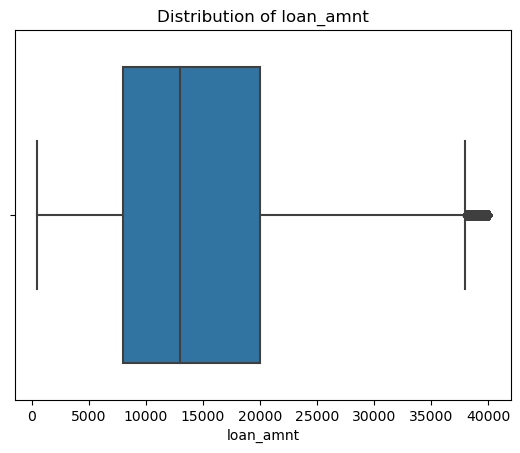

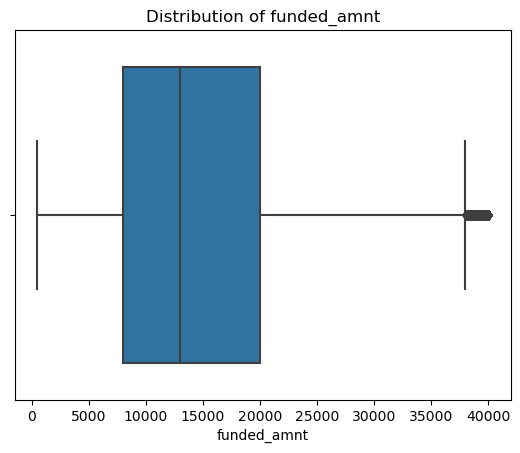

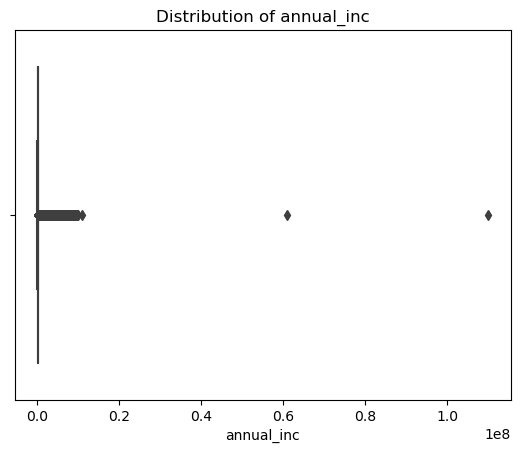

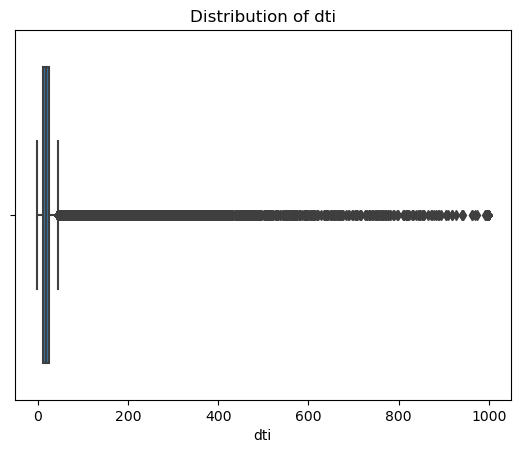

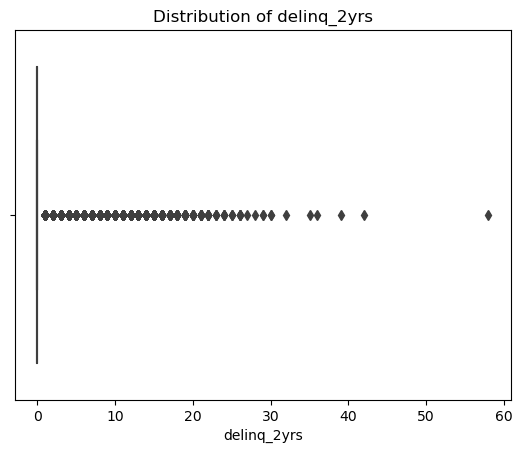

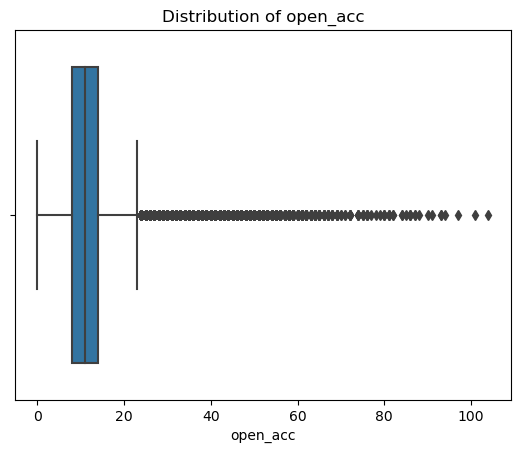

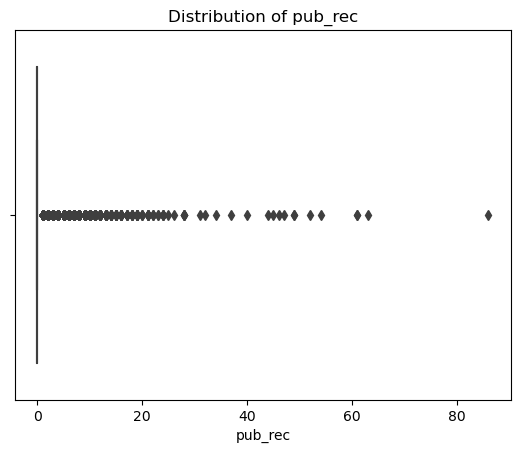

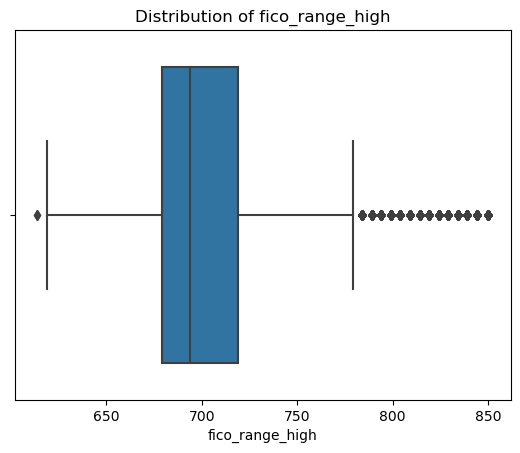

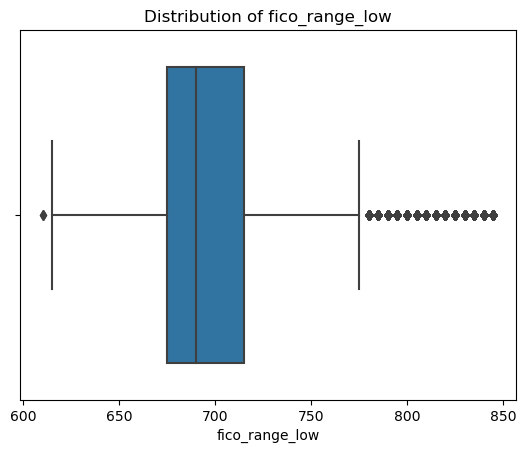

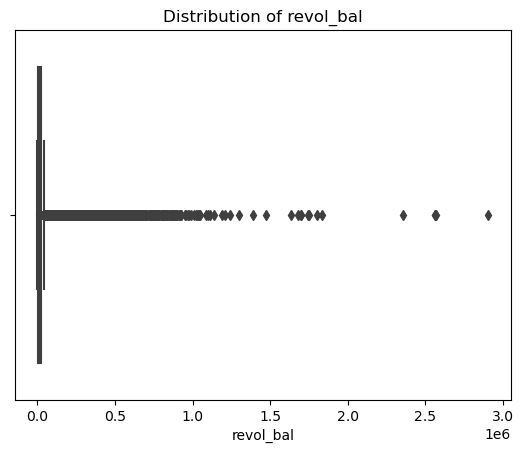

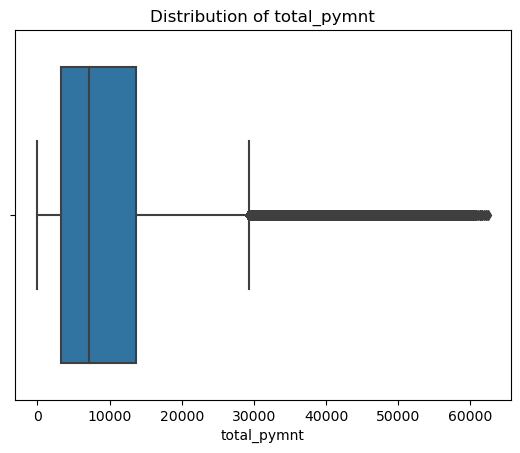

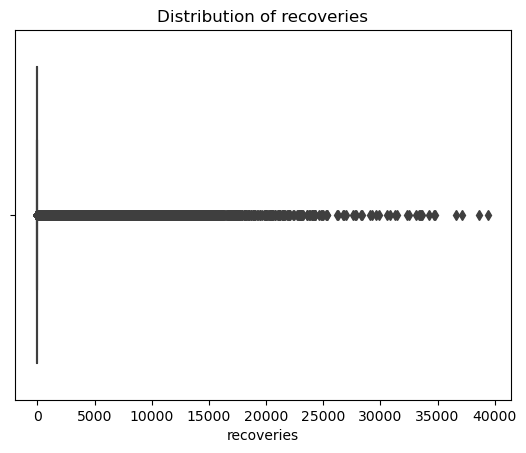

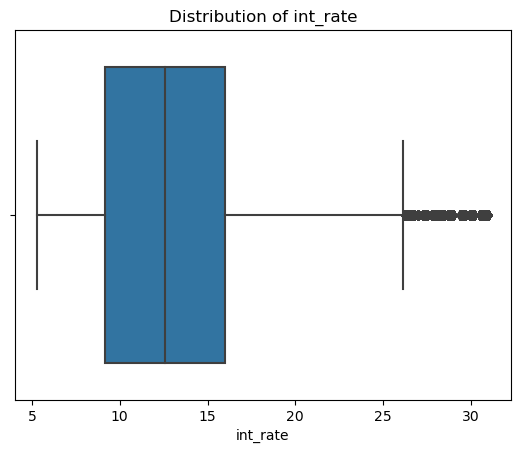

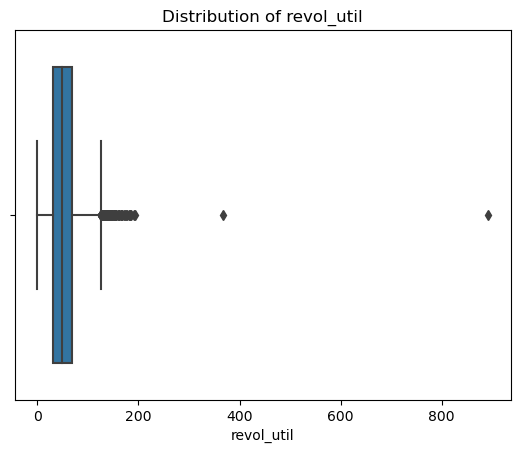

Column: term
Number of distinct values: 2
term
 36 months    1947319
 60 months     814799
Name: count, dtype: int64




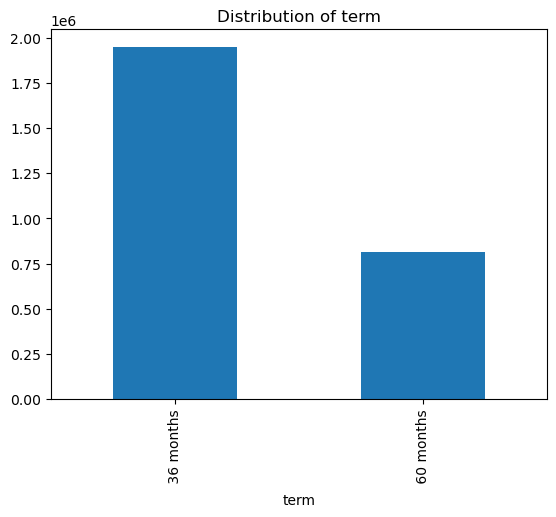

Column: grade
Number of distinct values: 7
grade
B    810672
C    767781
A    595897
D    396411
E    137921
F     41450
G     11986
Name: count, dtype: int64




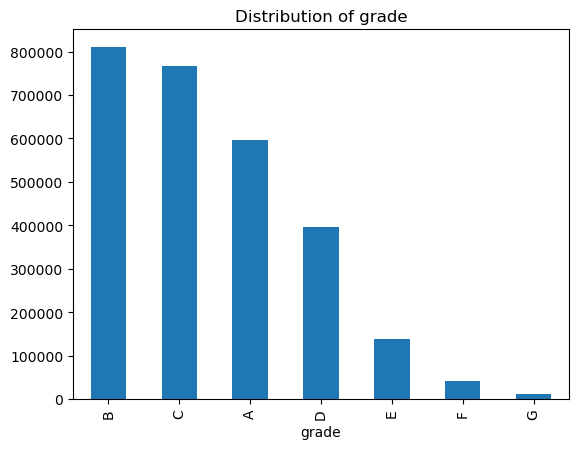

Column: emp_length
Number of distinct values: 11
emp_length
10+ years    897562
< 1 year     253308
2 years      247089
3 years      219473
1 year       182798
5 years      171573
4 years      166329
6 years      123540
7 years      109983
8 years      107362
9 years       91342
Name: count, dtype: int64




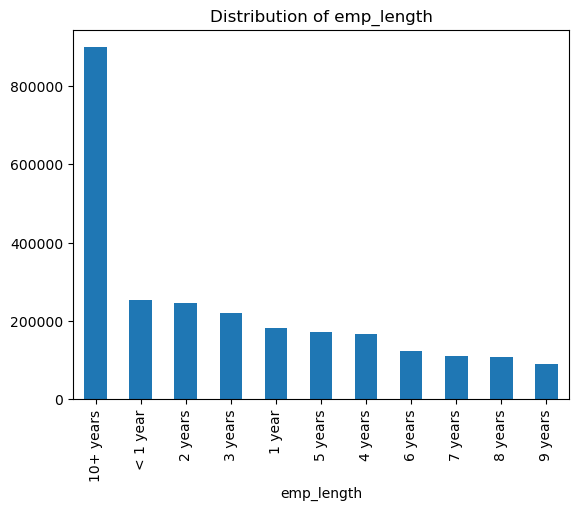

Column: home_ownership
Number of distinct values: 6
home_ownership
MORTGAGE    1357826
RENT        1089070
OWN          311595
ANY            3390
OTHER           182
NONE             55
Name: count, dtype: int64




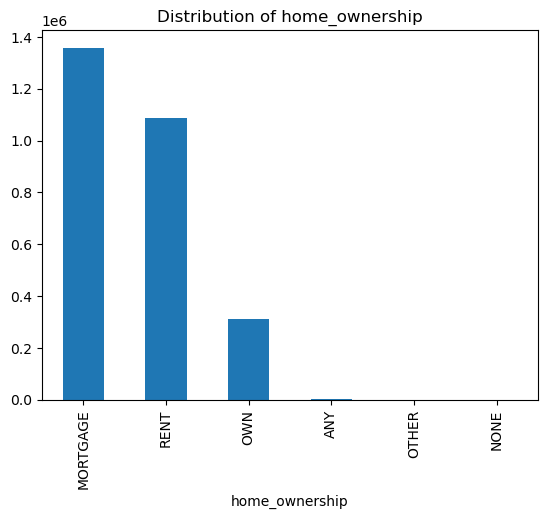

Column: verification_status
Number of distinct values: 3
verification_status
Source Verified    1065494
Not Verified        996591
Verified            700033
Name: count, dtype: int64




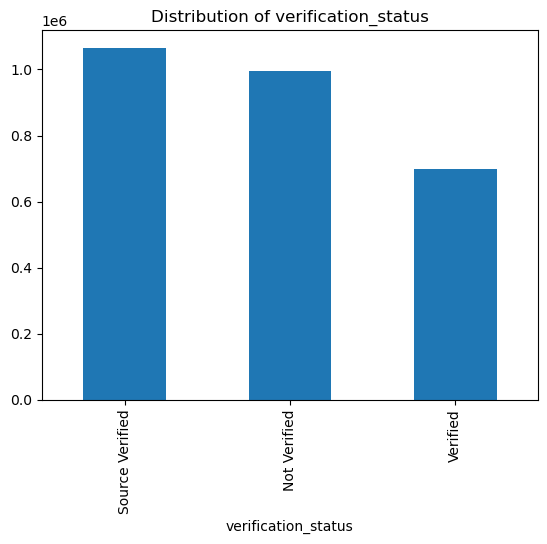

Column: loan_status
Number of distinct values: 9
loan_status
Current                                                1559755
Fully Paid                                              901142
Charged Off                                             235079
Late (31-120 days)                                       33803
In Grace Period                                          19614
Late (16-30 days)                                         9049
Does not meet the credit policy. Status:Fully Paid        1988
Default                                                    939
Does not meet the credit policy. Status:Charged Off        749
Name: count, dtype: int64




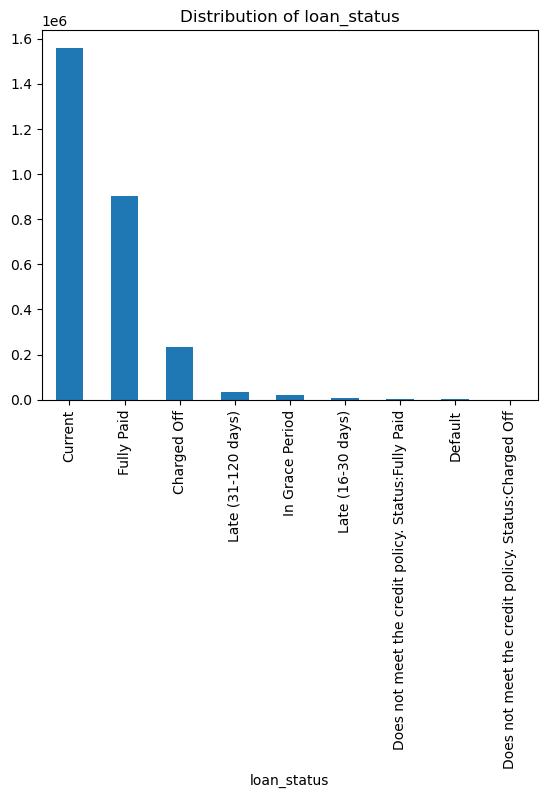

Column: purpose
Number of distinct values: 14
purpose
debt_consolidation    1551563
credit_card            653450
home_improvement       181170
other                  167299
major_purchase          58928
medical                 33093
small_business          28520
car                     28144
vacation                19150
house                   18308
moving                  18056
wedding                  2342
renewable_energy         1674
educational               421
Name: count, dtype: int64




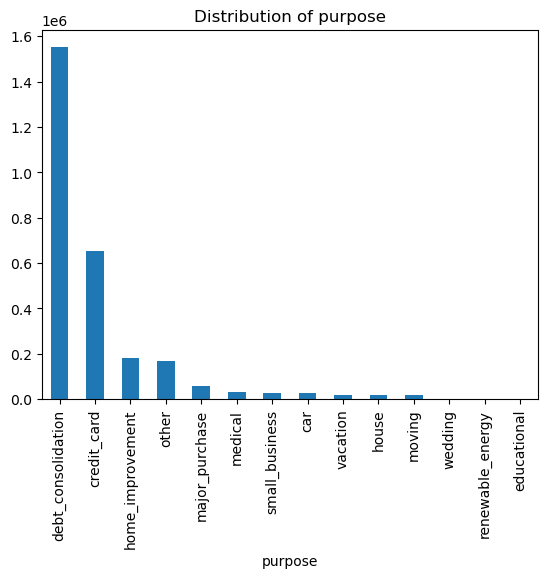

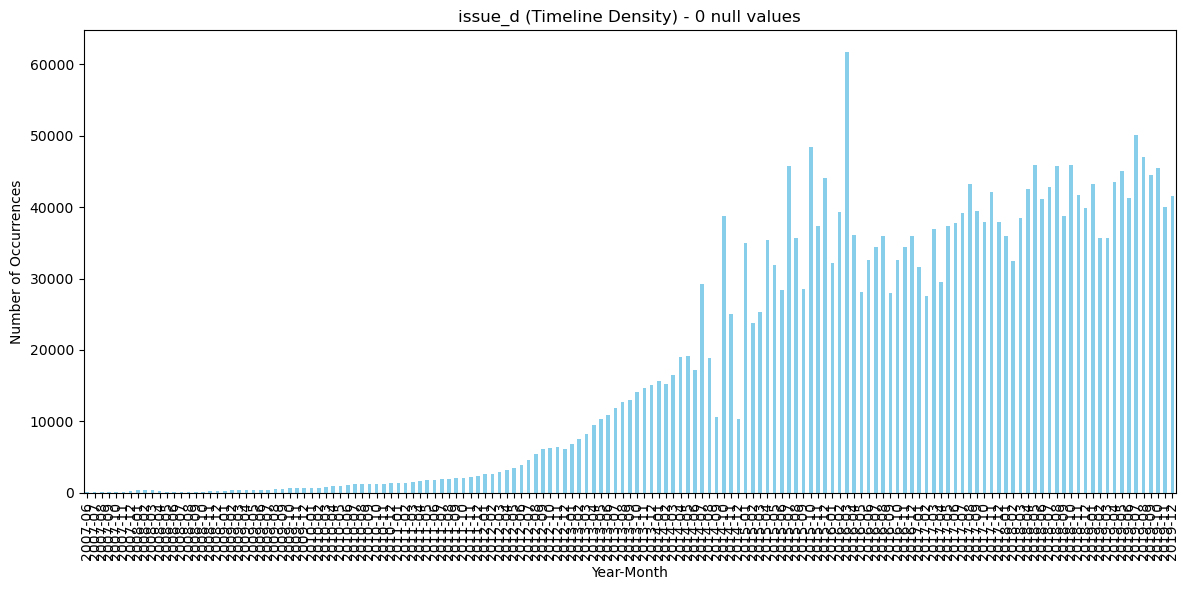

AttributeError: Can only use .dt accessor with datetimelike values

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Visualize continuous features
def visualize_float_columns(final_data, float_cols, perc_cols):
    # Float columns
    for col in float_cols + perc_cols:
        sns.boxplot(x=final_data[col])
        plt.title(f'Distribution of {col}')
        plt.show()

# Visualize categorical features
def visualize_cat_columns(final_data, cat_cols):
    # Categorical columns
    for col in cat_cols:
        print(f"Column: {col}")
        print(f"Number of distinct values: {final_data[col].nunique()}")
        value_counts = final_data[col].value_counts()
        print(value_counts)
        print("\n")
        value_counts.plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.show()

# Visualize date columns
def visualize_date_columns(final_data, date_cols):
    # Date columns
    for col in date_cols:
        timeline = final_data.loc[final_data[col].notnull(), col].dt.to_period('M')
        timeline_counts = timeline.value_counts().sort_index(ascending=True)
        timeline_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
        plt.title(f"{col} (Timeline Density) - {final_data[col].isnull().sum()} null values")
        plt.xlabel('Year-Month')
        plt.ylabel('Number of Occurrences')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# Now you call each function passing the relevant columns
# Assuming final_data is your DataFrame containing all the data

visualize_float_columns(final_data, float_cols, perc_cols)
visualize_cat_columns(final_data, cat_cols)
visualize_date_columns(final_data, date_cols)

### Handle outliers

In [ ]:
#final_data = data

In [30]:
# There are quite a few outliers.
#Please identify top-k (decide this based on the visualization) features where outliers are most obvious
#n_rows = len(final_data)

#final_data = final_data[final_data['annual_inc'] < 60000000] # remove outliers based 1st obvious feature
#final_data = final_data[final_data['delinq_2yrs'] < 50]  # remove outliers based 2nd obvious feature
#final_data = final_data[final_data['pub_rec'] < 80]
#final_data = final_data[final_data['revol_bal'] < 2000000]
#final_data = final_data[final_data['revol_util'] < 350]

#print("Removed " + str(n_rows - len(final_data)) + " rows")

n_rows = len(final_data)
print(n_rows)

final_data = final_data[(final_data['annual_inc'] >= final_data['annual_inc'].quantile(0.25) - 1.5 * (final_data['annual_inc'].quantile(0.75) - final_data['annual_inc'].quantile(0.25))) & (final_data['annual_inc'] <= final_data['annual_inc'].quantile(0.75) + 1.5 * (final_data['annual_inc'].quantile(0.75) - final_data['annual_inc'].quantile(0.25)))] # remove outliers based 1st obvious feature
final_data = final_data[(final_data['dti'] >= final_data['dti'].quantile(0.25) - 1.5 * (final_data['dti'].quantile(0.75) - final_data['dti'].quantile(0.25))) & (final_data['dti'] <= final_data['dti'].quantile(0.75) + 1.5 * (final_data['dti'].quantile(0.75) - final_data['dti'].quantile(0.25)))] # remove outliers based 2nd obvious feature
final_data = final_data[(final_data['open_acc'] >= final_data['open_acc'].quantile(0.25) - 1.5 * (final_data['open_acc'].quantile(0.75) - final_data['open_acc'].quantile(0.25))) & (final_data['open_acc'] <= final_data['open_acc'].quantile(0.75) + 1.5 * (final_data['open_acc'].quantile(0.75) - final_data['open_acc'].quantile(0.25)))] # remove outliers based 3rd obvious feature
final_data = final_data[(final_data['revol_bal'] >= final_data['revol_bal'].quantile(0.25) - 1.5 * (final_data['revol_bal'].quantile(0.75) - final_data['revol_bal'].quantile(0.25))) & (final_data['revol_bal'] <= final_data['revol_bal'].quantile(0.75) + 1.5 * (final_data['revol_bal'].quantile(0.75) - final_data['revol_bal'].quantile(0.25)))] # remove outliers based 4th obvious feature
final_data = final_data[(final_data['total_pymnt'] >= final_data['total_pymnt'].quantile(0.25) - 1.5 * (final_data['total_pymnt'].quantile(0.75) - final_data['total_pymnt'].quantile(0.25))) & (final_data['total_pymnt'] <= final_data['total_pymnt'].quantile(0.75) + 1.5 * (final_data['total_pymnt'].quantile(0.75) - final_data['total_pymnt'].quantile(0.25)))] # remove outliers based 5th obvious feature
final_data = final_data[(final_data['recoveries'] >= final_data['recoveries'].quantile(0.25) - 1.5 * (final_data['recoveries'].quantile(0.75) - final_data['recoveries'].quantile(0.25))) & (final_data['recoveries'] <= final_data['recoveries'].quantile(0.75) + 1.5 * (final_data['recoveries'].quantile(0.75) - final_data['recoveries'].quantile(0.25)))] # remove outliers based 6th obvious feature
final_data = final_data[(final_data['delinq_2yrs'] >= final_data['delinq_2yrs'].quantile(0.25) - 1.5 * (final_data['delinq_2yrs'].quantile(0.75) - final_data['delinq_2yrs'].quantile(0.25))) & (final_data['delinq_2yrs'] <= final_data['delinq_2yrs'].quantile(0.75) + 1.5 * (final_data['delinq_2yrs'].quantile(0.75) - final_data['delinq_2yrs'].quantile(0.25)))] # remove outliers based 7th obvious feature
final_data = final_data[(final_data['pub_rec'] >= final_data['pub_rec'].quantile(0.25) - 1.5 * (final_data['pub_rec'].quantile(0.75) - final_data['pub_rec'].quantile(0.25))) & (final_data['pub_rec'] <= final_data['pub_rec'].quantile(0.75) + 1.5 * (final_data['pub_rec'].quantile(0.75) - final_data['pub_rec'].quantile(0.25)))] # remove outliers based 8th obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

2762118
Removed 1304504 rows


In [31]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status'] != 'Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 899294 rows


In [32]:
# Only include loans isssued since 2010
'''n_rows = len(final_data)

final_data['issue_d'] = pd.to_datetime(final_data['issue_d'])
final_data = final_data[final_data['issue_d'].dt.year >= 2010]

print("Removed " + str(n_rows - len(final_data)) + " rows")'''

n_rows = len(final_data)

final_data = final_data.loc[final_data['issue_d'] >= pd.to_datetime("2010-01-01")]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 4998 rows


### Drop null values

In [33]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data = final_data.dropna(subset=required_cols) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 400 rows


### Visualize clean data

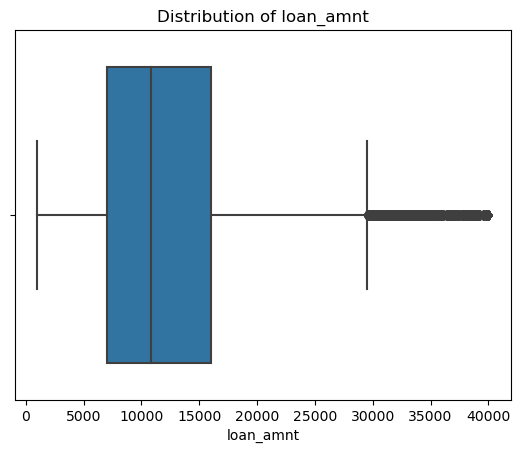

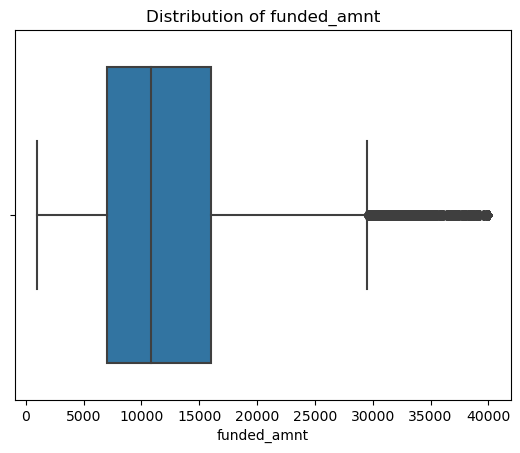

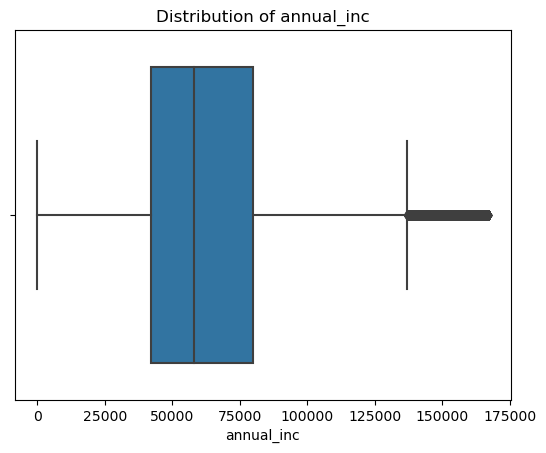

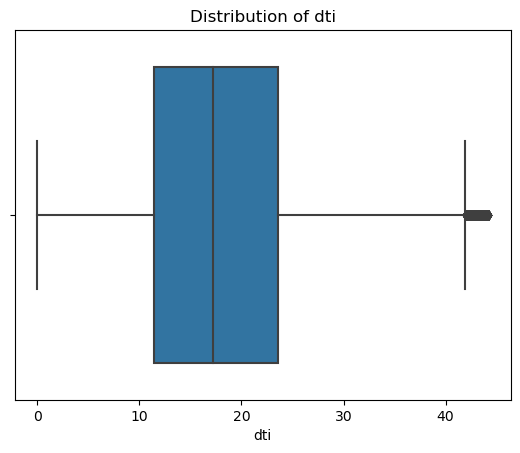

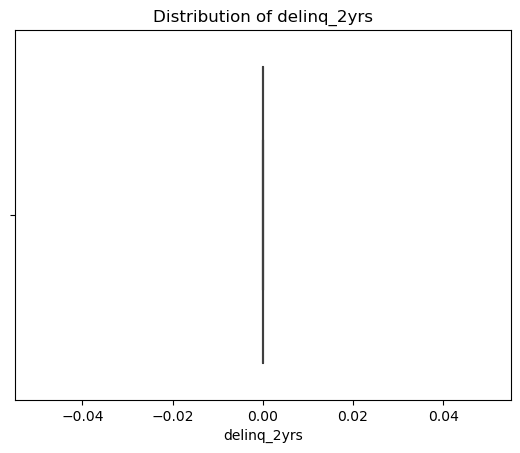

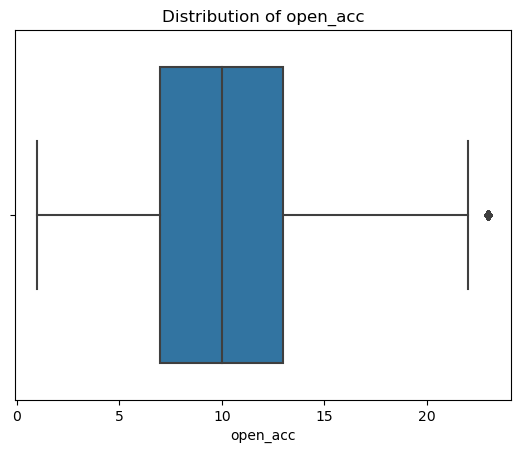

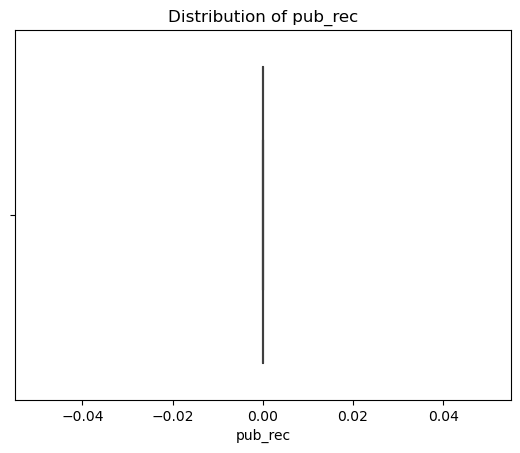

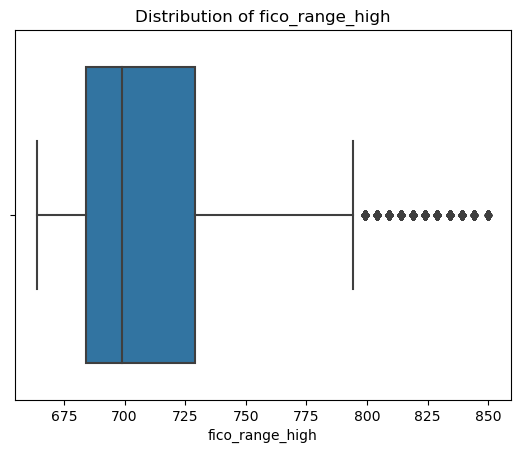

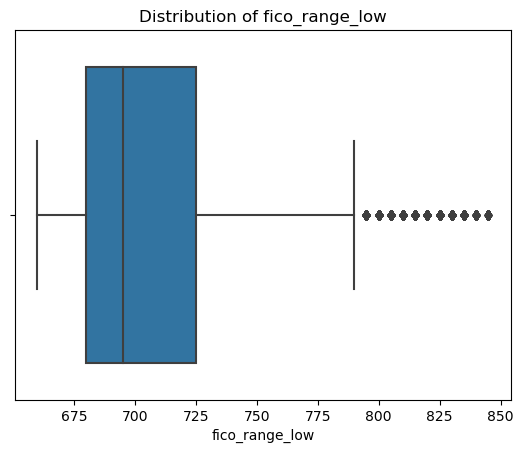

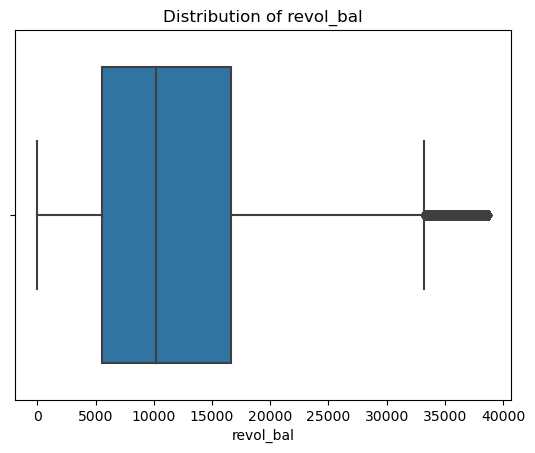

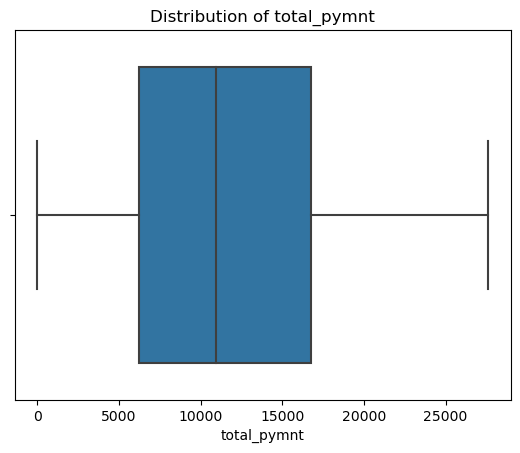

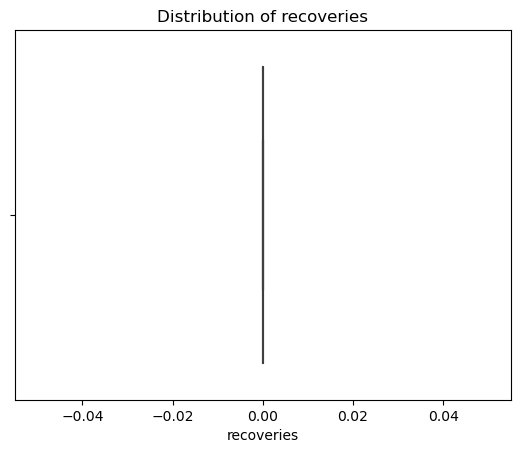

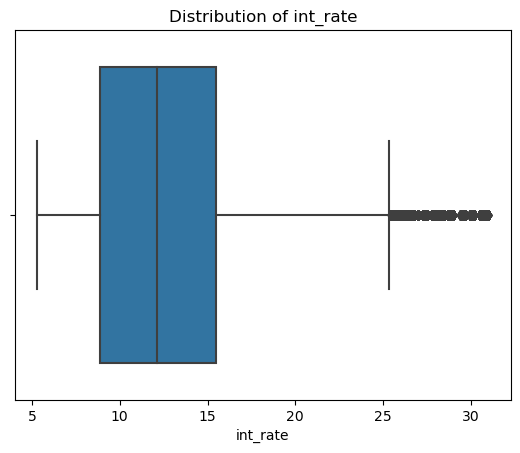

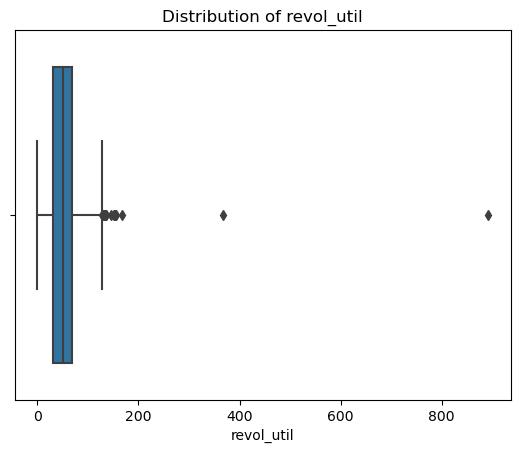

Column: term
Number of distinct values: 2
term
 36 months    445953
 60 months    106969
Name: count, dtype: int64




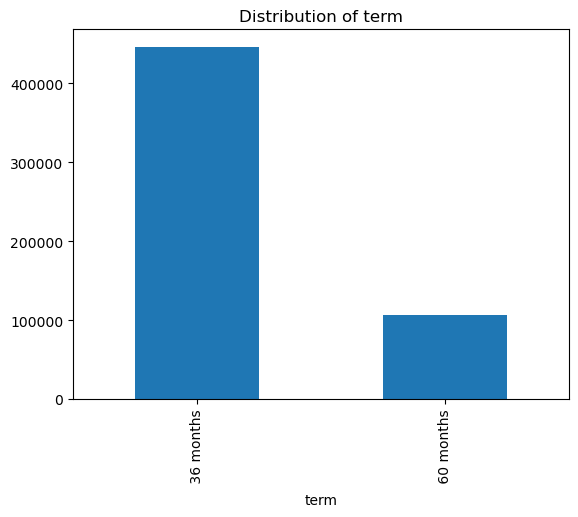

Column: grade
Number of distinct values: 7
grade
B    167534
C    142281
A    130067
D     74217
E     28475
F      8263
G      2085
Name: count, dtype: int64




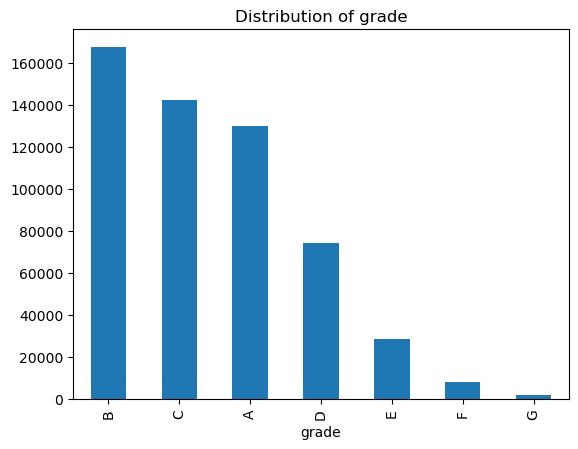

Column: emp_length
Number of distinct values: 11
emp_length
10+ years    158532
2 years       53893
< 1 year      49479
3 years       47905
1 year        39800
5 years       37384
4 years       36131
6 years       27387
7 years       25109
8 years       24064
9 years       19439
Name: count, dtype: int64




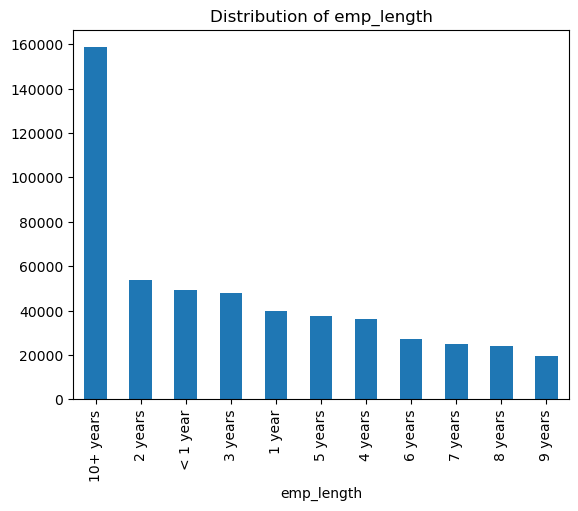

Column: home_ownership
Number of distinct values: 6
home_ownership
RENT        246678
MORTGAGE    245683
OWN          60095
ANY            420
OTHER           27
NONE            19
Name: count, dtype: int64




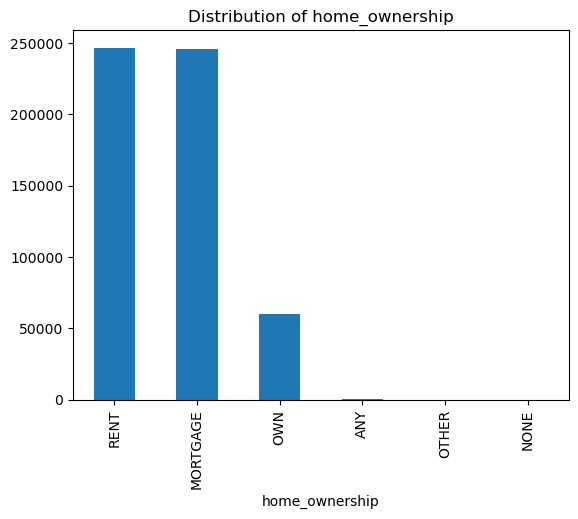

Column: verification_status
Number of distinct values: 3
verification_status
Not Verified       217843
Source Verified    196590
Verified           138489
Name: count, dtype: int64




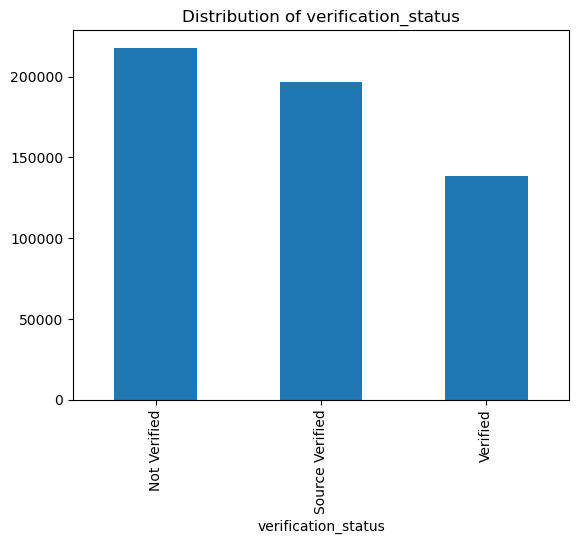

Column: loan_status
Number of distinct values: 7
loan_status
Fully Paid                                            467073
Charged Off                                            51609
Late (31-120 days)                                     18363
In Grace Period                                        10299
Late (16-30 days)                                       4646
Default                                                  523
Does not meet the credit policy. Status:Fully Paid       409
Name: count, dtype: int64




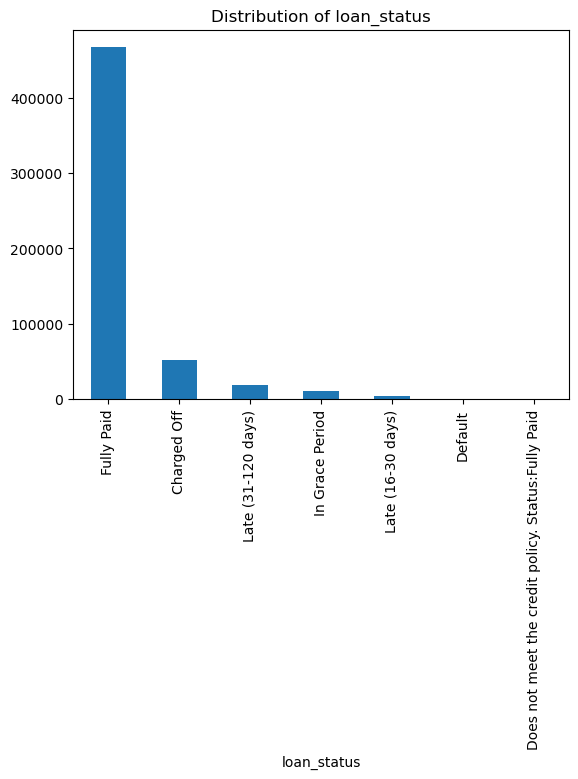

Column: purpose
Number of distinct values: 14
purpose
debt_consolidation    312745
credit_card           127744
other                  34797
home_improvement       31464
major_purchase         13336
car                     7123
medical                 6664
small_business          5178
moving                  4452
vacation                4332
house                   3260
wedding                 1352
renewable_energy         406
educational               69
Name: count, dtype: int64




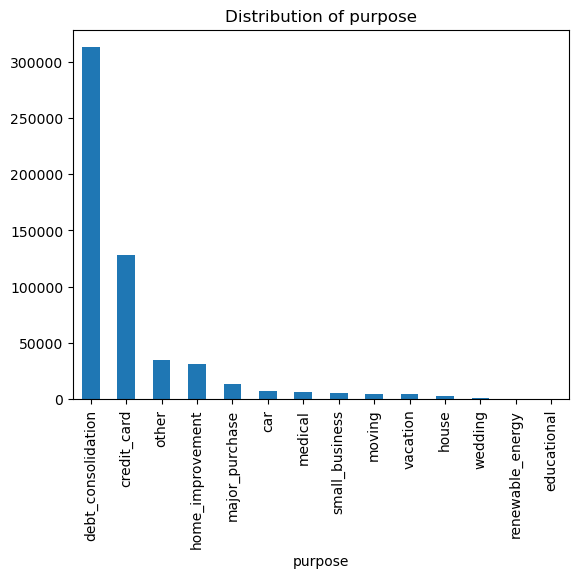

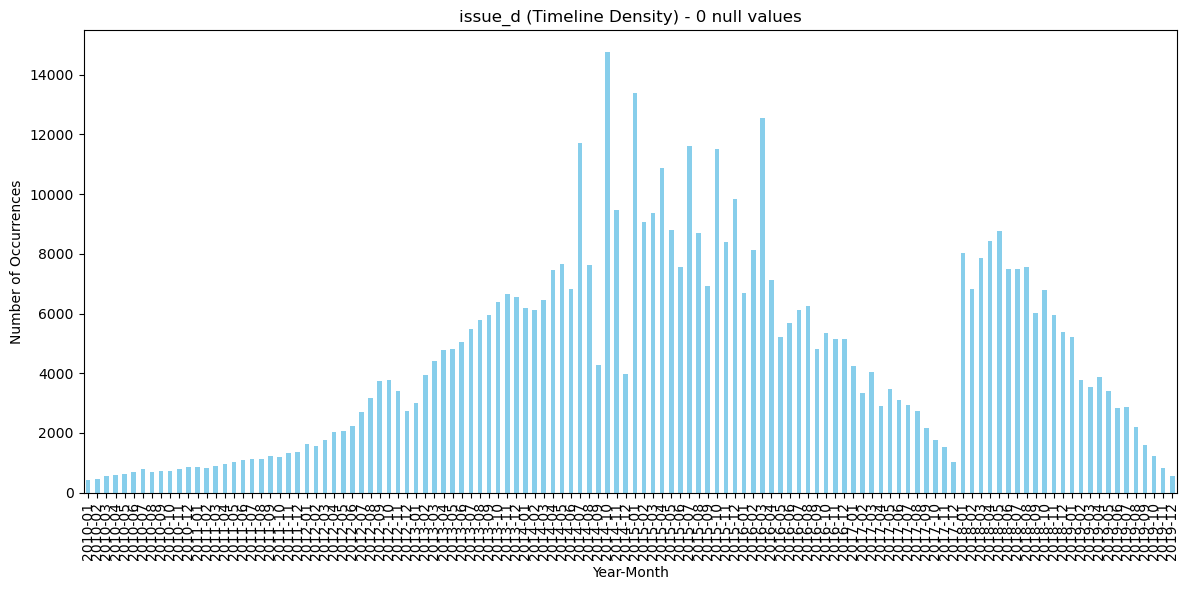

AttributeError: Can only use .dt accessor with datetimelike values

In [34]:
# Visualize the data again after cleaning
visualize_float_columns(final_data, float_cols, perc_cols)
visualize_cat_columns(final_data, cat_cols)
visualize_date_columns(final_data, date_cols)

What do you observe after removing the outliers?

The plots in general open up a bit more and we can analyze the data more effectively after we removed outliers.
We observe that the median shifts to the left in distribution of loan_amnt, funded_amnt, fico_range_high, fico_range_low.

We can read and understand the plot of revol_util much better than before

In annual_inc, dti, delinq_2yrs, open_acc, pub_rec, revol_bal, recoveries even after removing some outliers, there are many more outliers which means that the variance is high for these features.

The values on the y-axis distributions of term, grade, emp_length, home_ownership, verification_status, loan_status, purpose, earliest_cr_line drop but the distribution more or less remains the same.

We can analyze the distribution of issue_d and last_payment_d in much more detail after removing outliers.


In [37]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby('grade')['ret_OPT'].mean()# average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby('grade')['ret_PESS'].mean() # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby('grade')['ret_INTa'].mean() # average return for M3
ret_by_grade_INTb = final_data.groupby('grade')['ret_INTb'].mean()# # average return for M3
int_rate_by_grade = final_data.groupby('grade')['int_rate'].mean() # average interest rate for each grade

#print(ret_by_grade_OPT)
combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
grade,,,,,,,
A,23.523571,6.009979,7.171966,0.039525,0.011856,2.781668,4.451452
B,30.299753,11.114162,10.913098,0.055375,0.015257,2.950826,4.617175
C,25.732563,18.794498,14.240827,0.062438,0.007189,2.390947,4.033397
D,13.422689,25.868736,18.190474,0.069357,0.000958,1.823528,3.426698
E,5.149913,32.927129,21.533076,0.076905,-0.004420,1.402593,2.976174
F,1.494424,37.988624,25.190059,0.086521,-0.006708,0.967278,2.509410
G,0.377088,45.899281,28.112859,0.072144,-0.034063,-1.205116,0.222866


Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?